# Spaceship Titanic
- `PassengerId` : 각 승객에 대한 고유 ID입니다. 각 ID는 ggg_pp 형식을 취하며, 여기서 ggg는 승객과 함께 여행하는 그룹을 나타내고 pp는 해당 그룹 내의 번호
    한 그룹의 사람들은 종종 가족 구성원이지만 항상 그런 것은 아니다.
- `HomePlanet` : 승객이 출발한 행성(일반적으로 영구 거주 행성)
- `CryoSleep` : 승객이 항해 중 일시 중단된 애니메이션을 선택했는지 여부, 저온수면에 있는 승객들은 그들의 선실에 갇혀있다.
- `Cabin` : 승객이 머무는 객실 번호입니다. deck/num/side 형식을 취하며, 여기서 side는 좌현에 대해 P 또는 우현에 대해 S
- `Destination` : 승객이 하차할 행성
- `Age` : 탑승자의 연령
- `VIP` : 승객이 여행 중 특별 VIP 서비스를 위해 비용을 지불했는지 여부
룸서비스, 푸드코트, 쇼핑몰, 스파, VR데크 - 승객이 우주선 타이타닉의 많은 고급 편의시설에서 청구한 금액
- `Name` : 승객의 이름과 성
- `Transported` : 승객이 다른 차원으로 운송되었는지 여부. 예측하려는 목표값

# Library & Data Load

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# pip install lazypredict

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report

from sklearn.svm import SVC, LinearSVC

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree
from lightgbm import LGBMClassifier
from lightgbm import plot_importance, plot_metric, plot_tree

from sklearn.impute import SimpleImputer
import lazypredict
from lazypredict.Supervised import LazyClassifier
from IPython.display import clear_output
import time

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')

# Exploring Data
## Train 

In [ ]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


- print문으로 콘솔창에 색상 표시하는 방법 ex) \033[94m
- 참고 사이트 : https://blog.naver.com/shiesqnpfr8/222638647753

In [ ]:
print(f'\033[94mNumber of rows in train data : {train.shape[0]}')  # 행 개수
print(f'\033[94mNumber of columns in train data : {train.shape[1]}')  # 열 개수
print(f'\033[94mNumber of values in train data : {train.count().sum()}')  
print(f'\033[94mNumber missing values in train data : {sum(train.isna().sum())}')  # 결측치 합계

Number of rows in train data : 8693
Number of columns in train data : 14
Number of values in train data : 119378
Number missing values in train data : 2324


In [ ]:
print(train.isnull().sum().sort_values(ascending=False))  # 컬럼별 결측치 개수 내림차순 정렬

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


In [ ]:
train.describe()  # 기술 통계량

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


## Test

In [ ]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.00,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.00,False,0.00,9.00,0.00,2823.00,0.00,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.00,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.00,False,0.00,6652.00,0.00,181.00,585.00,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.00,False,10.00,0.00,635.00,0.00,0.00,Brence Harperez


In [ ]:
print(f'\033[94mNumber of rows in test data : {test.shape[0]}')  # 행 개수
print(f'\033[94mNumber of columns in test data: {test.shape[1]}')  # 열 개수
print(f'\033[94mNumber of values in test data: {test.count().sum()}')
print(f'\033[94mNo of rows with missing values  in test data: {sum(test.isna().sum())}')  # 결측치 합계

Number of rows in test data : 4277
Number of columns in test data: 13
Number of values in test data: 54484
No of rows with missing values  in test data: 1117


In [ ]:
print(test.isnull().sum().sort_values(ascending=False))  # 컬럼별로 결측치 합계 내림차순 정렬

FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


In [ ]:
test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.00,4195.00,4171.00,4179.00,4176.00,4197.00
mean,28.66,219.27,439.48,177.30,303.05,310.71
std,14.18,607.01,1527.66,560.82,1117.19,1246.99
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,26.00,0.00,0.00,0.00,0.00,0.00
75%,37.00,53.00,78.00,33.00,50.00,36.00
max,79.00,11567.00,25273.00,8292.00,19844.00,22272.00


## Submission

In [ ]:
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


# EDA

## Overview of Data

In [ ]:
train = train.drop(["PassengerId"], axis=1)  # PassengerId 컬럼 제거
test = test.drop(["PassengerId"], axis=1)  # PassengerId 컬럼 제거

In [ ]:
target = "Transported"  # target 변수명
Features = [col for col in train.columns if col != target]  # target 변수가 아닌 컬럼만 Features에 담음
random_state = 12

In [ ]:
# 기술 통계량 구한 후 표준편차(std)를 기준으로 내림차순 정렬
# 값이 큰 행을 강조하기 위해 style.background_gradient 사용
# max, mean 컬럼에 색상 입히기

train.iloc[:, :-1].describe().T.sort_values(by="std", ascending=False)\
    .style.background_gradient(cmap="GnBu")\
    .bar(subset=["max"], color="#BB0000")\
    .bar(subset=["mean"], color="green")

,count,mean,std,min,25%,50%,75%,max
FoodCourt,8510.00,458.08,1611.49,0.00,0.00,0.00,76.00,29813.00
VRDeck,8505.00,304.85,1145.72,0.00,0.00,0.00,46.00,24133.00
Spa,8510.00,311.14,1136.71,0.00,0.00,0.00,59.00,22408.00
RoomService,8512.00,224.69,666.72,0.00,0.00,0.00,47.00,14327.00
ShoppingMall,8485.00,173.73,604.70,0.00,0.00,0.00,27.00,23492.00
Age,8514.00,28.83,14.49,0.00,19.00,27.00,38.00,79.00


## Null Value Distribution

In [ ]:
train_null = pd.DataFrame(train.isna().sum()).sort_values(by=0, ascending=False)[:-1]  # 마지막 변수인 target 변수를 제외한 결측치 개수 구한 후 내림차순 정렬
test_null = pd.DataFrame(test.isna().sum()).sort_values(by=0, ascending=False)

In [ ]:
# make_subplots(행, 열, 각 그래프 제목, 전체 그래프 x축명)
fig = make_subplots(rows=1, cols=2,
                    column_titles=["Train Data", "Test Data"],
                    x_title="Missing Vakyes")

# fig_add_trace를 통해 그래프 추가하기
fig.add_trace(go.Bar(x=train_null[0], y=train_null.index,
                     orientation="h",
                     marker=dict(color=[n for n in range(12)],
                                 line_color="rgb(0, 0, 0)",
                                 line_width=2,
                                 coloraxis="coloraxis")),
              1, 1)  # 그래프 위치 지정

# fig.add_trace를 통해 그래프 추가하기
fig.add_trace(go.Bar(x=test_null[0], y=test_null.index,
                     orientation="h",
                     marker=dict(color=[n for n in range(12)],
                                 line_color="rgb(0, 0, 0)",
                                 line_width=2,
                                 coloraxis="coloraxis")),
              1, 2)  # 그래프 위치 지정

# fig.update_layout을 통해 범례(legend)를 False로 설정하고, 전체 그래프 제목 설정하여 나타내기
fig.update_layout(showlegend=False, title_text="Column wise Null value Distribution", title_x=0.5)

In [ ]:
missing_train_row = train.isna().sum(axis=1)  # 각 행별로 결측치 합계
missing_train_row = pd.DataFrame(missing_train_row.value_counts() / train.shape[0]).reset_index()  # 빈도수를 셍 비율을 계산 후 데이터프레임으로 변환

missing_test_row = test.isna().sum(axis=1)  # 각 행별로 결측치 합계
missing_test_row = pd.DataFrame(missing_test_row.value_counts() / test.shape[0]).reset_index()  # 빈도수를 셍 비율을 계산 후 데이터프레임으로 변환

missing_train_row.columns = ["no", "count"]  # 컬럼명 설정
missing_test_row.columns = ["no", "count"]

missing_train_row["count"] = missing_train_row["count"] * 100  # 비율을 구하기 위해 * 100
missing_test_row["count"] = missing_test_row["count"] * 100

In [ ]:
# make_subplots(행, 열, 각 그래프 제목, 전체 그래프 x축명)
fig = make_subplots(rows=1, cols=2,
                    column_titles=["Train Data", "Test Data"],
                    x_title="Missing Values")

# fig.add_trace를 통해 그래프 추가하기
fig.add_trace(go.Bar(x=missing_train_row["no"], y=missing_train_row["count"],
                     marker=dict(color=[n for n in range(12)],
                                 line_color="rgb(0, 0, 0)",
                                 line_width=2,
                                 coloraxis="coloraxis")),
              1, 1)  # 그래프 위치 지정

# fig.add_trace를 통해 그래프 추가하기
fig.add_trace(go.Bar(x=missing_test_row["no"], y=missing_test_row["count"],
                     marker=dict(color=[n for n in range(12)],
                                 line_color="rgb(0, 0, 0)",
                                 line_width=2,
                                 coloraxis="coloraxis")),
              1, 2)  # 그래프 위치 지정

# fig.update_layout을 통해 범례(legend)를 False로 설정하고, 전체 그래프 제목 설정하여 나타내기
fig.update_layout(showlegend=False, title_text="Row wise Null Values Distribution", title_x=0.5)

## Continous and Categorical Data Distribution

In [ ]:
# 앞서 지정한 Features들에 해당하는 train과 test를 행 병합
df = pd.concat([train[Features], test[Features]], axis=0)

In [ ]:
text_features = ["Cabin", "Name"]  # 컬럼명

# 고유값 개수가 25개 미만이고, 컬럼명이 Cabin, Name이 아닌 컬럼만 리스트에 담기
cat_features = [col for col in Features if df[col].nunique() < 25 and col not in text_features]

# 고유값 개수가 25개 이상이고, 컬럼명이 Cabin, Name이 아닌 컬럼만 리스트에 담기
cont_features = [col for col in Features if df[col].nunique() >= 25 and col not in text_features]

In [ ]:
del df  # 위에서 병합하여 만든 데이터프레임 제거

print(f'\033[94mTotal number of features: {len(Features)}')
print(f'\033[94mNumber of categorical features: {len(cat_features)}')
print(f'\033[94mNumber of continuos features: {len(cont_features)}')
print(f'\033[94mNumber of text features: {len(text_features)}')

Total number of features: 12
Number of categorical features: 4
Number of continuos features: 6
Number of text features: 2


In [ ]:
# 그래프를 그리기 위한 옵션을 변수로 지정
labels = ["Categorical", "Continuos", "Text"]
values = [len(cat_features), len(cont_features), len(text_features)]
colors = ["#DE3163", "#58D68D"]

In [ ]:
# go.Figure와 go.Pie를 이용하여 파이차트 그리기
# labels, values, marker 옵션 지정
# pull은 강조하는 정도를 나타내는 값
# marker에 line은 파이차트의 테두리 색상, width는 선의 굵기

fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values, pull=[0.1, 0, 0],
    marker=dict(colors=colors,
                line=dict(color="#000000",
                          width=2))
)])
fig.show()

## Feature Distributuion of Continous Features

In [ ]:
# 기존 데이터프레임 복사
train_age = train.copy()
test_age = test.copy()

# Train, Test 값이 입력되는 type 컬럼 생성
train_age["type"] = "Train"
test_age["type"] = "Test"

# train_age와 test_age 데이터프레임 병합
ageDf = pd.concat([train_age, test_age])

In [ ]:
# plotly.express를 이용해 히스토그램 그리기
# type 컬럼 범주별로 색상 다르게 지정
# boxplot
# 히스토그램 구간 100개
fig = px.histogram(data_frame=ageDf, x="Age",
                   color="type", color_discrete_sequence=["#58D68D", "#DE3163"],
                   marginal="box",
                   nbins=100,
                   template="plotly_white")

# 전체 그래프 제목 설정
fig.update_layout(title="Distribution of Age", title_x=0.5)
fig.show()

## Feature Distribution of Categorical Features

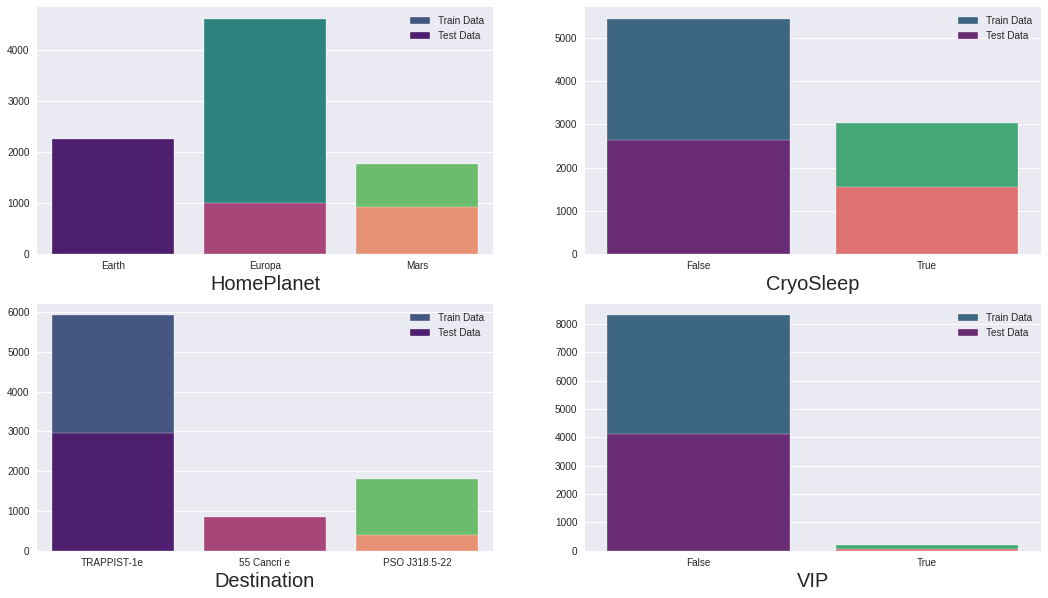

In [ ]:
# cat_features 컬럼이 없다면 print문 출력
# cat_features : ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
if len(cat_features) == 0:
    print("No Categorical features")

else:
    ncols = 2
    nrows = 2

    # plt.subplots(행, 열, 그래프 사이즈) -> 2 * 2 그래프
    fig, ax = plt.subplots(nrows, ncols, figsize=(18, 10))

    # [0, 0], [0, 1], [1, 0], [1, 1] 위치대로 그래프 그리기 -> ax에 지정하여 그래프 위치 설정
    for r in range(nrows):
        for c in range(ncols):

            # [r*ncols+c]을 계산하면 0, 1, 2, 3이 나타남 -> 0번째 컬럼, ..., 3번째 컬럼
            col = cat_features[r*ncols+c]

            # seaborn의 countplot
            sns.countplot(train[col], ax=ax[r, c], palette="viridis", label="Train Data")
            sns.countplot(test[col], ax=ax[r, c], palette="magma", label="Test Data")
            
            ax[r, c].legend()  # 범례
            ax[r, c].set_ylabel('')  # y축 label 공백으로 만들기
            ax[r, c].set_xlabel(col, fontsize=20)  # x축 label에 컬럼명으로 설정, 폰트 사이즈 설정
            ax[r, c].tick_params(labelsize=10, width=0.5)  # 눈금 스타일 지정
            ax[r, c].xaxis.offsetText.set_fontsize(4)  
            ax[r, c].yaxis.offsetText.set_fontsize(4)  
    plt.show()

## Target Distribution

In [ ]:
# target 변수(True/False) 빈도수 데이터프레임으로 변환
target_df = pd.DataFrame(train[target].value_counts()).reset_index()

# 컬럼명 변경
target_df.columns = [target, "count"]
target_df

,Transported,count
0,True,4378
1,False,4315


In [ ]:
# px를 이용한 barplot 그리기 -> px.bar(data_frame, x, y)
fig = px.bar(data_frame=target_df,
             x=target,
             y="count")

fig.update_traces(marker_color=["#58D68D", "#DE3163"],
                  marker_line_color="rgb(0, 0, 0)",
                  marker_line_width=2)

fig.update_layout(title="Target Distribution",
                  template="plotly_white",
                  title_x=0.5)

In [ ]:
print("\033[94mPercentage of Transported = 0: {:.2f} %".format(target_df["count"][0] *100 / train.shape[0]))
print("\033[94mPercentage of Transported = 1: {:.2f} %".format(target_df["count"][1]* 100 / train.shape[0]))

Percentage of Transported = 0: 50.36 %
Percentage of Transported = 1: 49.64 %


## Correlation Matrix

In [ ]:
fig = px.imshow(train.corr(),
                text_auto=True, aspect="auto",
                color_continuous_scale="viridis")
fig.show()

# Data Pre-Processing

## Imputing Missing Values 

In [ ]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "RoomService"]  # Null이 들어있는 컬럼

imputer = SimpleImputer(strategy="mean")
imputer.fit(train[imputer_cols])

train[imputer_cols] = imputer.transform(train[imputer_cols])
test[imputer_cols] = imputer.transform(test[imputer_cols])

train["HomePlanet"].fillna("Z", inplace=True)
test["HomePlanet"].fillna("Z", inplace=True)

## Encoding Categorical Faatures 

In [ ]:
label_cols = ["HomePlanet", "CryoSleep", "Cabin", "Destination", "VIP"]  # 범주형 컬럼

def label_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] = LabelEncoder().fit_transform(test[col])

    return train, test

train, test = label_encoder(train, test, label_cols)

In [ ]:
train.drop(["Name", "Cabin"], axis=1, inplace=True)
test.drop(["Name", "Cabin"], axis=1, inplace=True)

X = train.drop(target, axis=1)
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=12)  # 데이터 셋 분할

# Modeling

In [ ]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     predictions=False,
                     random_state=12,
                     classifiers="all")

models, predictions = clf.fit(X_train, X_test, y_train, y_test)
clear_output()

## TOP 15 Models

In [ ]:
models[:15]  # Top15

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.78,0.78,0.78,0.78,0.22
XGBClassifier,0.78,0.78,0.78,0.78,0.41
AdaBoostClassifier,0.78,0.78,0.78,0.78,0.58
RandomForestClassifier,0.77,0.77,0.77,0.77,0.83
SVC,0.77,0.77,0.77,0.77,4.10
BaggingClassifier,0.77,0.77,0.77,0.77,0.45
LinearSVC,0.77,0.77,0.77,0.77,0.40
LogisticRegression,0.77,0.77,0.77,0.77,0.05
NuSVC,0.77,0.77,0.77,0.77,2.36


## Visualizing Results 

In [ ]:
line = px.line(data_frame=models,
               y=["Accuracy"],
               markers=True)

line.update_xaxes(title="Model", rangeslider_visible=False)
line.update_yaxes(title="Accuracy")
line.update_traces(line_color="red")
line.update_layout(showlegend=True,
                   title={
                       "text" : "Accuracy vs Model",
                       "y" : 0.94,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"
                   })

line.show()

In [ ]:
line = px.line(data_frame=models,
               y=["ROC AUC", "F1 Score"],
               markers=True)

line.update_xaxes(title="Model",
                  rangeslider_visible=False)
line.update_yaxes(title="ROC AUC Score")
line.update_layout(showlegend=True,
                   title={
                       "text" : "ROC AUC and F1 Score vs Model",
                       "y" : 0.94,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"
                   })

line.show()

In [ ]:
line = px.line(data_frame=models,
               y=["Time Taken"],
               markers=True)

line.update_xaxes(title="Model",
                  rangeslider_visible=False)
line.update_yaxes(title="Time(s)")
line.update_traces(line_color="purple")
line.update_layout(showlegend=True,
                   title={
                       "text" : "Time Taken vs Model",
                       "y" : 0.94,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"
                   })

line.show()

## LGBM Classifier(5 Fold)

In [ ]:
lgb_params = {
    "objective" : "binary",
    "n_estimators" : 50,
    "learning_rate" : 0.08
}

In [ ]:
lgb_predictions = 0
lgb_scores = []
lgb_fimp = []

LGBM_Features = list(train.columns)[:-1]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train[LGBM_Features], train[target])):
    print(f"\033[94m")
    print(10 * "=", f"Fold={fold+1}", 10 * "=")

    start_time = time.time()

    X_train, X_valid = train.iloc[train_idx][LGBM_Features], train.iloc[valid_idx][LGBM_Features]
    y_train, y_valid = train[target].iloc[train_idx], train[target].iloc[valid_idx]

    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train, verbose=0)

    preds_valid = model.predict(X_valid)
    acc = accuracy_score(y_valid, preds_valid)
    lgb_scores.append(acc)

    run_time = time.time() - start_time

    fim = pd.DataFrame(index=LGBM_Features,
                       data=model.feature_importances_,
                       columns=[f"{fold}_importance"])
    lgb_fimp.append(fim)

    print(f"Fold={fold+1}, Accuracy score: {acc:.2f}%, Run Time: {run_time:.2f}s")
    test_preds = model.predict(test[LGBM_Features]) 
    lgb_predictions += test_preds/5
    print("")
    print("Mean Accuracy :", np.mean(lgb_scores))


========== Fold=1 ==========
Fold=1, Accuracy score: 0.80%, Run Time: 0.21s

Mean Accuracy : 0.8027602070155262

========== Fold=2 ==========
Fold=2, Accuracy score: 0.78%, Run Time: 0.19s

Mean Accuracy : 0.7926969522714205

========== Fold=3 ==========
Fold=3, Accuracy score: 0.79%, Run Time: 0.20s

Mean Accuracy : 0.7914510254935787

========== Fold=4 ==========
Fold=4, Accuracy score: 0.79%, Run Time: 0.20s

Mean Accuracy : 0.7913730792467664

========== Fold=5 ==========
Fold=5, Accuracy score: 0.80%, Run Time: 0.22s

Mean Accuracy : 0.79374288226968


## Feature Importance 

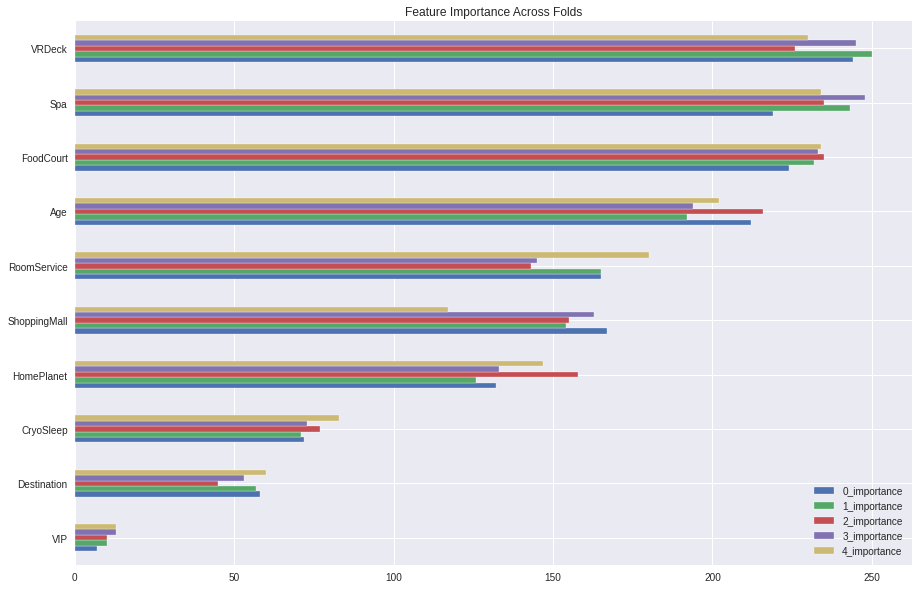

In [ ]:
lgbm_fis_df = pd.concat(lgb_fimp, axis=1).head(15)
lgbm_fis_df.sort_values("1_importance").plot(kind="barh", figsize=(15, 10),
                                             title="Feature Importance Across Folds")
plt.show()

# Submission

In [ ]:
submission[target] = lgb_predictions.astype("bool")
submission.to_csv("submission.csv",index=False)
submission.head()